# Sentiment Analysis Portion

### Here, we will be utilizing the pretrained VADER algorithm to measure the sentiment level of our text messages. 

#### VADER (Valence Aware Dictionary and sEntiment Reasoner) is a sentiment analysis tool specifically designed for sentiment analysis of text. It is a lexicon and rule-based sentiment analysis tool, which means it relies on a combination of pre-defined sentiment lexicons and grammatical rules to determine the sentiment of a given text, giving it a negativity, neutrality and positivity score, as well as a compound total score.

# Loading Modules

In [7]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
import seaborn as sns

# Sentiment Analysis Preprocessing

### Datetime transformations for visualization after sentiment analysis

In [8]:
merged_df = pd.read_pickle('Extracted_Transformed_LangTagged.pkl')

merged_df['timestamp_ms'] = merged_df['timestamp_ms'] - pd.Timedelta(hours=4)

merged_df['year'] = merged_df['timestamp_ms'].dt.year
merged_df['month'] = merged_df['timestamp_ms'].dt.month
merged_df['date'] = merged_df['timestamp_ms'].dt.date
merged_df['hour'] = merged_df['timestamp_ms'].dt.hour

### Getting total messages over the years

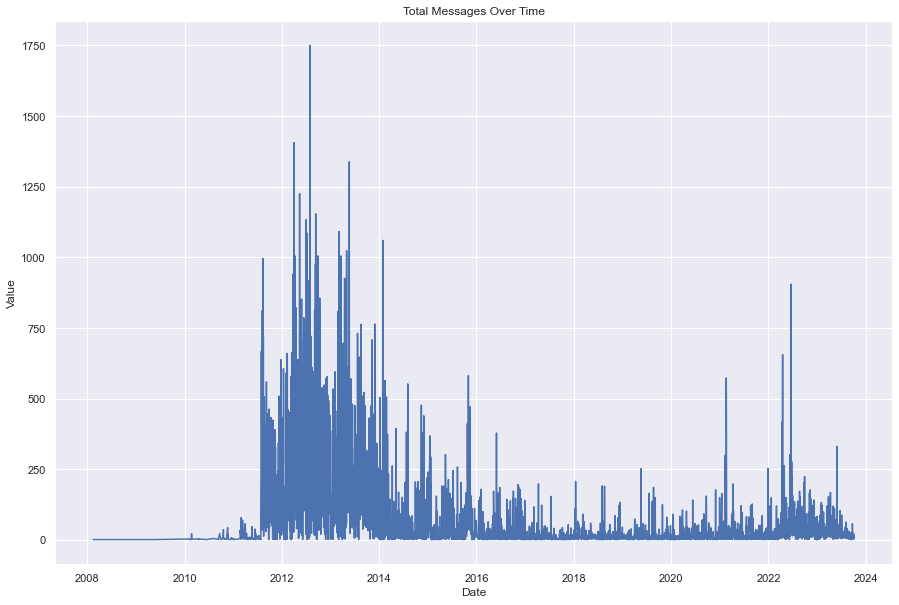

In [13]:
# Placeholder metric to count the rows when grouping
merged_df['MessageCounter'] = 1

df_date = merged_df.groupby('date')['MessageCounter'].value_counts().unstack().fillna(0)

df_date['Total_Messages'] = df_date.sum(axis=1)

# Use Seaborn to create line plots
sns.set(style="darkgrid")

# Plot a linegraph with the messages over time
sns.lineplot(data=df_date['Total_Messages'])
plt.title("Total Messages Over Time")
plt.xlabel("Date")
plt.ylabel("Value")

plt.show()

In [231]:
# Delete anything older than 2011-08 due to lack of data

merged_df = merged_df[merged_df['timestamp_ms'] > '2011-08-01']

### Since VADER currently only supports English, and Google Cloud translation was quite costly for my dataset, I will only be inclusing messages in English. Hopefully in the future I can translate!

In [245]:
# Limit to only english messages

merged_df = merged_df[(merged_df['Language'] == 'en') & (merged_df['Confidence'] > 0.95)]

merged_df.reset_index(drop=True)

print('We are left with {} messages.'.format(len(merged_df)))

We are left with 29140 messages.


### Running Sentiment Analysis

In [246]:
# Initializing sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Measure sentiment for all messages
merged_df['compound'] = [analyzer.polarity_scores(x)['compound'] for x in merged_df['content']]
merged_df['neg'] = [analyzer.polarity_scores(x)['neg'] for x in merged_df['content']]
merged_df['neu'] = [analyzer.polarity_scores(x)['neu'] for x in merged_df['content']]
merged_df['pos'] = [analyzer.polarity_scores(x)['pos'] for x in merged_df['content']]

In [247]:
# Setting simplified labels for overall message sentiment. Finer labels are generally used but I need a way
# to quickly visualize!

merged_df['Simple_Label'] = None

merged_df.loc[(merged_df['compound'] > -.1) & (merged_df['compound'] < .1), 'Simple_Label'] = 'Neutral'
merged_df.loc[(merged_df['compound'] <= -.1), 'Simple_Label'] = 'Negative'
merged_df.loc[(merged_df['compound'] >= .1), 'Simple_Label'] = 'Positive'

### Data segmentation and visualization

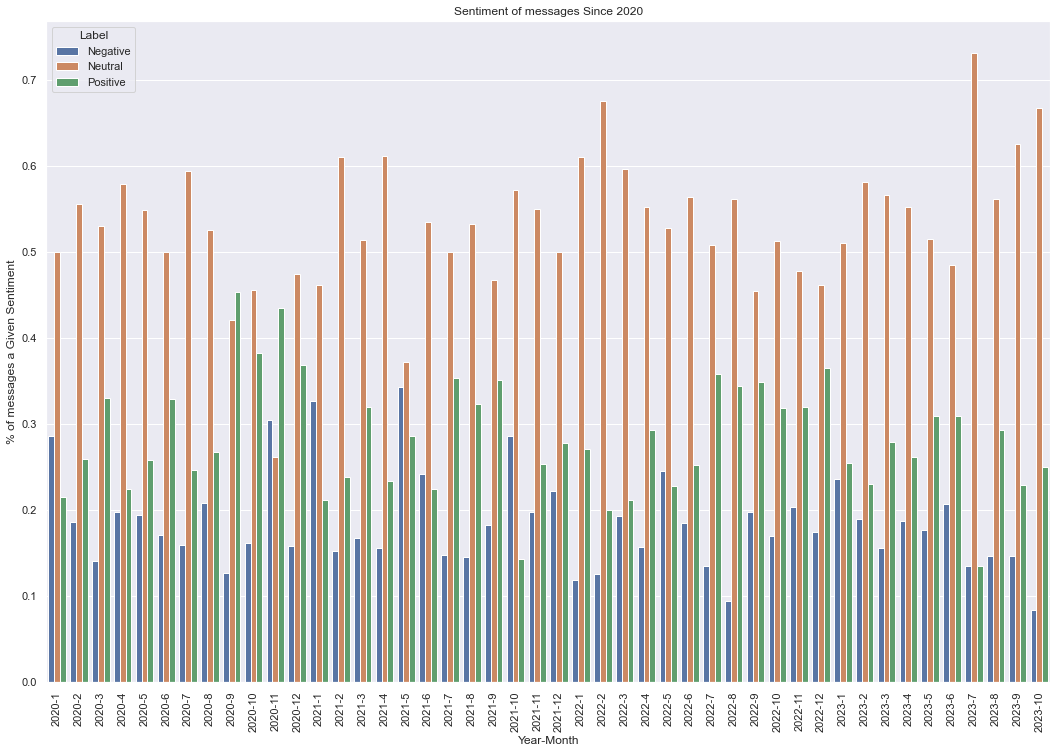

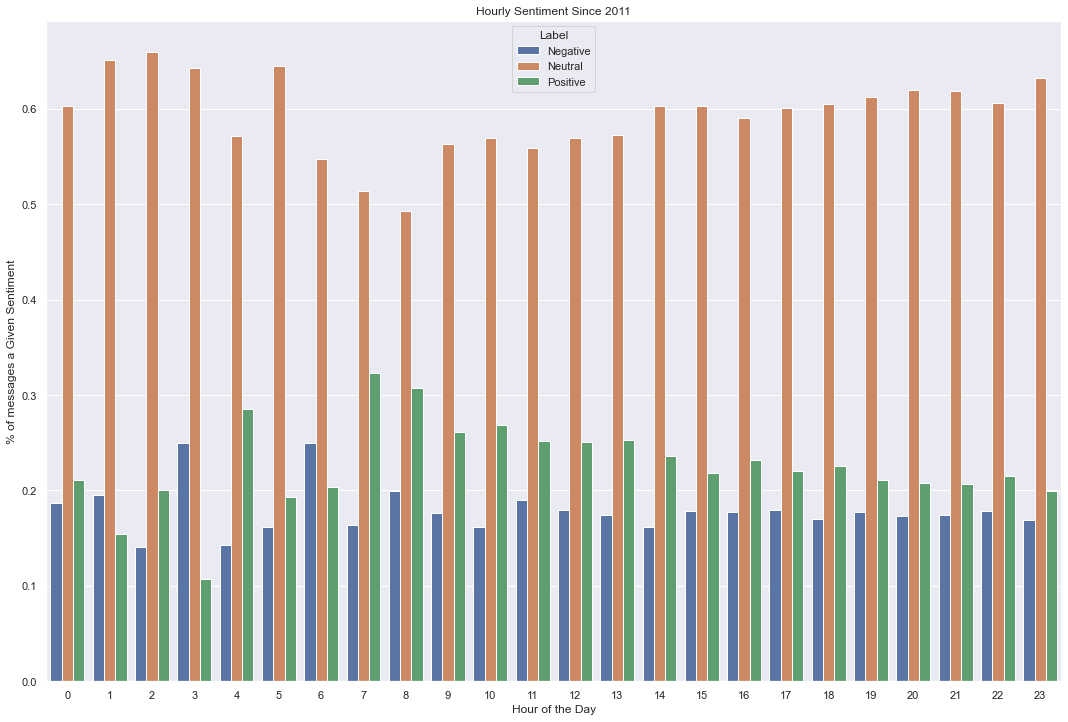

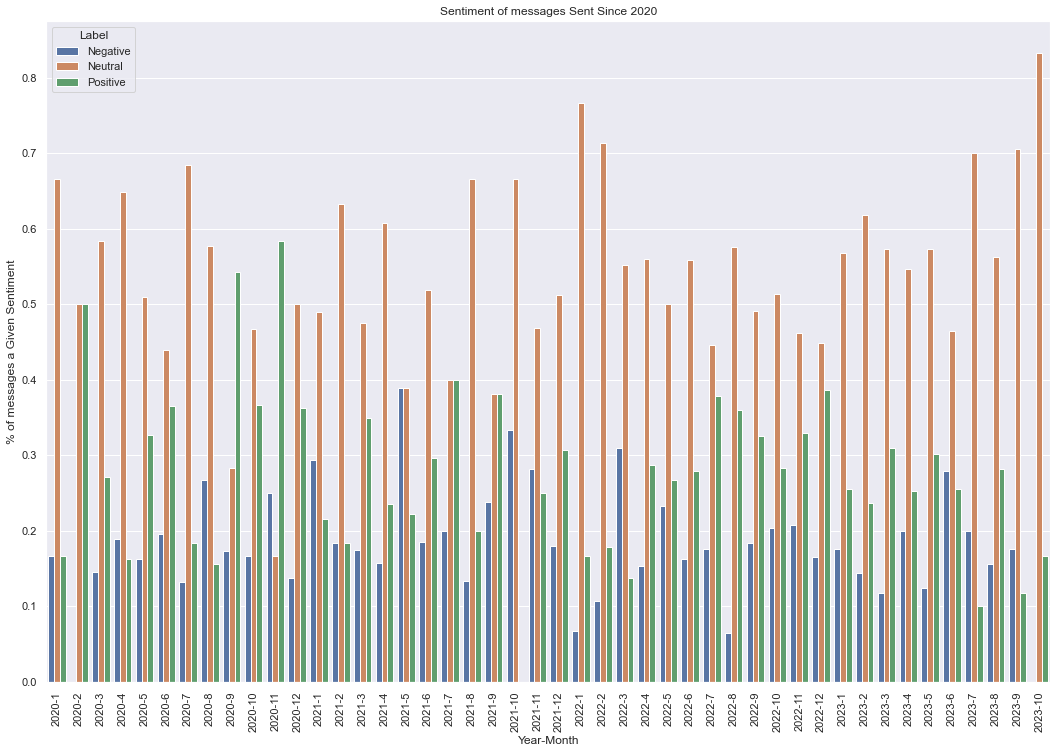

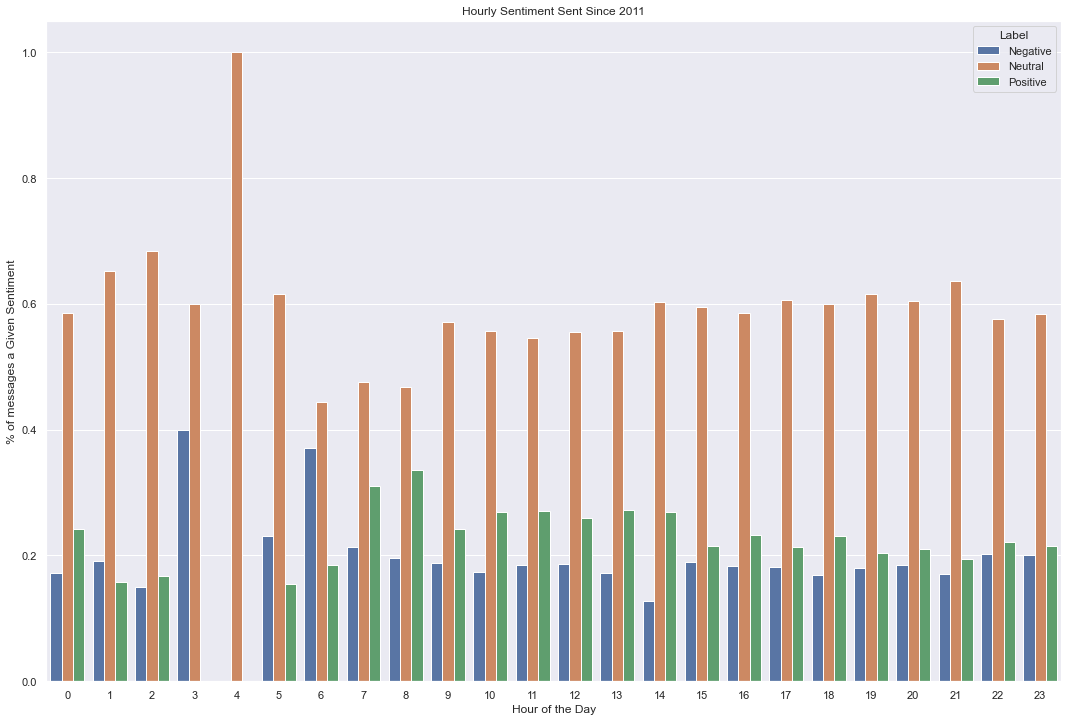

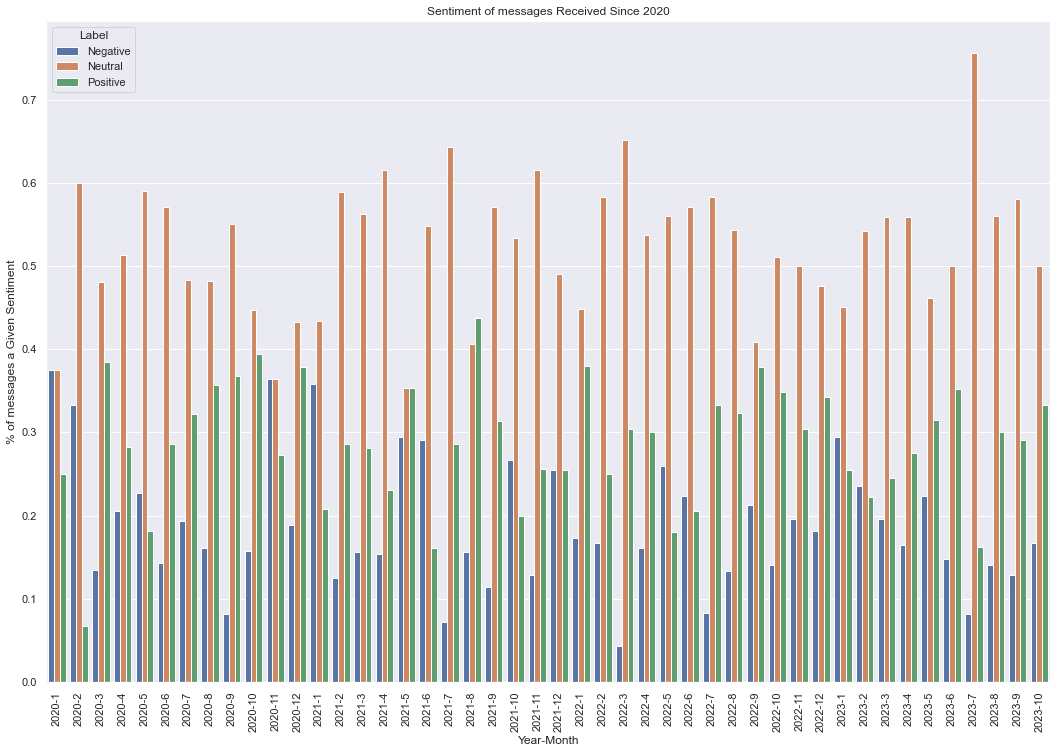

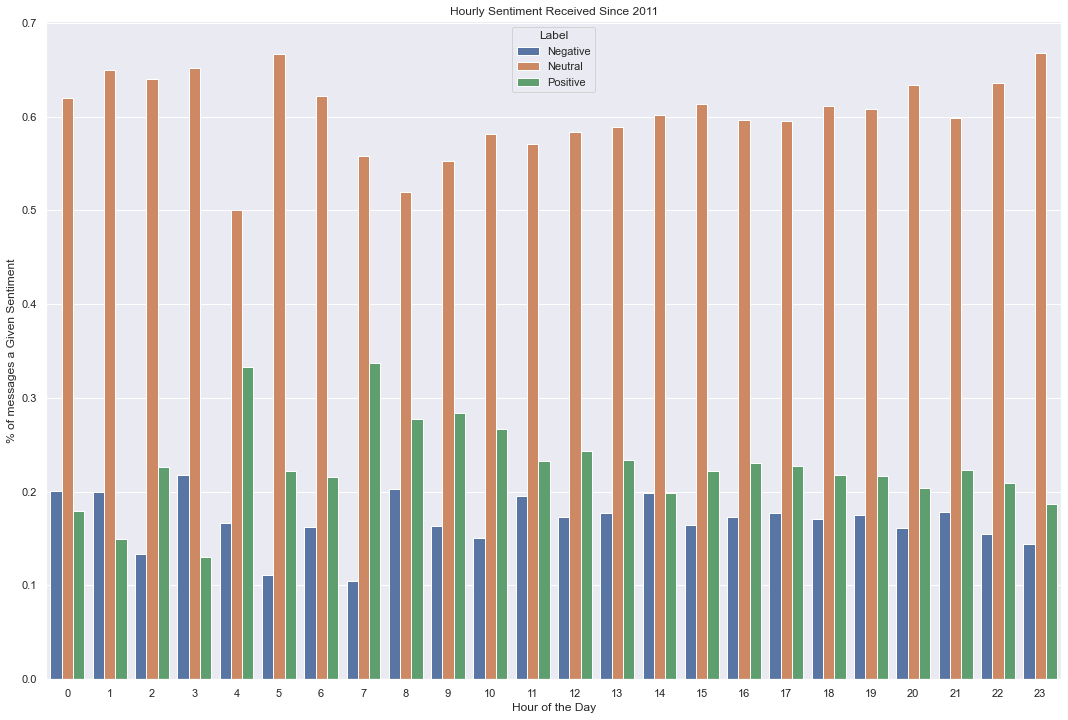

In [244]:
# Getting separate dataframes for messages sent and messages received.

merged_df_sent = merged_df[merged_df['sender_name'] == 'Marcos Grillo']
merged_df_received = merged_df[merged_df['sender_name'] != 'Marcos Grillo']

# List for iteration
dfs = [[merged_df, ''], [merged_df_sent, ' Sent'], [merged_df_received, ' Received']]

for df, status in dfs:
    # Grouping by year and month    
    df_yearmonth = df.groupby(['year', 'month'])['Simple_Label'].value_counts().unstack().fillna(0)

    # Getting aggregate message metric
    df_yearmonth['Total_Messages'] = df_yearmonth.sum(axis=1)
    
    # Getting % sentiment metrics
    df_yearmonth['Negative'] = df_yearmonth['Negative']/df_yearmonth['Total_Messages']
    df_yearmonth['Neutral'] = df_yearmonth['Neutral']/df_yearmonth['Total_Messages']
    df_yearmonth['Positive'] = df_yearmonth['Positive']/df_yearmonth['Total_Messages']

    # Index reset
    df_yearmonth.reset_index(inplace=True)    

    # Creating string column to then make visualization neat
    df_yearmonth['YearMonth'] = df_yearmonth['year'].astype(str) + '-' + df_yearmonth['month'].astype(str)

    # Including data only starting from 2020 in order to keep chart readable
    df_yearmonth2020 = df_yearmonth[df_yearmonth['year'] > 2019]

    # Melting to have all data in one graph
    melted_yearmonth2020 = pd.melt(df_yearmonth2020, id_vars=['YearMonth'], 
                                   value_vars=['Negative', 'Neutral', 'Positive'])

    # Plotting melted dataframe to view sentiment month over month starting 2020
    melted_yearmonth2020.rename(columns={"Simple_Label": "Label"}, inplace=True)
    
    sns.barplot(
        data=melted_yearmonth2020,
        x=melted_yearmonth2020['YearMonth'], y="value", hue='Label',
    )

    # Set the title and labels
    plt.tight_layout()
    plt.xticks(np.arange(0, len(df_yearmonth2020), step=1))
    plt.xticks(rotation=90)
    plt.title("Sentiment of messages{} Since 2020".format(status))
    plt.xlabel("Year-Month")
    plt.ylabel("% of messages a Given Sentiment")

    plt.show()
    
    # Grouping by year and month
    df_hour = df.groupby('hour')['Simple_Label'].value_counts().unstack().fillna(0)

    # Getting aggregate message metric
    df_hour['Total_Messages'] = df_hour.sum(axis=1)

    # Getting aggregate message metric
    df_hour['Negative'] = df_hour['Negative']/df_hour['Total_Messages']
    df_hour['Neutral'] = df_hour['Neutral']/df_hour['Total_Messages']
    df_hour['Positive'] = df_hour['Positive']/df_hour['Total_Messages']

    # Index reset
    df_hour.reset_index(inplace=True)
    
    # Melting to have all data in one graph
    melted_hour = pd.melt(df_hour, id_vars=['hour'], value_vars=['Negative', 'Neutral', 'Positive'])

    # Plotting melted dataframe to view sentiment on each hour of the day
    melted_hour.rename(columns={"Simple_Label": "Label"}, inplace=True)
    
    sns.barplot(
        data=melted_hour,
        x=melted_hour['hour'], y="value", hue='Label',
    )

    # Set the title and labels
    plt.tight_layout()
    plt.xticks(np.arange(0, len(df_hour), step=1))
    plt.title("Hourly Sentiment{} Since 2011".format(status))
    plt.xlabel("Hour of the Day")
    plt.ylabel("% of messages a Given Sentiment")

    plt.show()